In [ ]:
# Reference: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
# All necessary imports here
import os
import sys
import urllib.request

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import time

## Dataset

In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [3]:
#read pollutant values
# A N by T feature matrix, which describes the (f_1, .., f_T) speed records over T timesteps for the N sensors.
dfPollutant = pd.read_excel(
     "datasets/training/PM10.xlsx",
     engine='openpyxl',
     parse_dates=True,
     thousands='.'
)

# Remove index column e.g. Aksaray here
dfPollutant = dfPollutant.iloc [: , 1:2].to_numpy ().astype ('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dfPollutant = scaler.fit_transform(dfPollutant)

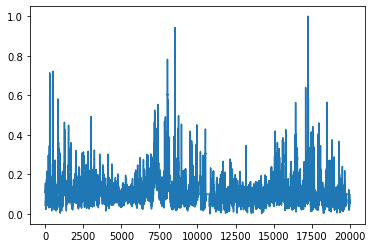

In [4]:
# Example distribution for a pollutant for single sensor across timestamps
plt.plot(dfPollutant)
plt.show()

In [5]:
# split into train and test sets
split_ratio = 0.67
train_size = int(len(dfPollutant) * split_ratio)
test_size = len(dfPollutant) - train_size
train, test = dfPollutant[0:train_size,:], dfPollutant[train_size:len(dfPollutant),:]
print("Train data: ", train.shape)
print("Test data: ", test.shape)

Train data:  (13400, 1)
Test data:  (6600, 1)


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1 according to the window size
seq_len = 10
trainX, trainY = create_dataset(train, seq_len)
testX, testY = create_dataset(test, seq_len)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(13389, 1, 10)
(13389,)
(6589, 1, 10)
(6589,)


## Model

In [7]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, seq_len)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
13389/13389 - 17s - loss: 0.0011
Epoch 2/10
13389/13389 - 15s - loss: 5.7365e-04
Epoch 3/10
13389/13389 - 13s - loss: 5.4771e-04
Epoch 4/10
13389/13389 - 14s - loss: 5.3253e-04
Epoch 5/10
13389/13389 - 13s - loss: 5.2550e-04
Epoch 6/10
13389/13389 - 13s - loss: 5.2351e-04
Epoch 7/10
13389/13389 - 13s - loss: 5.2053e-04
Epoch 8/10
13389/13389 - 13s - loss: 5.2086e-04
Epoch 9/10
13389/13389 - 13s - loss: 5.2036e-04
Epoch 10/10
13389/13389 - 12s - loss: 5.1745e-04


## Evaluation

In [8]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [9]:
# invert predictions because we applied scaling
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [10]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 8.22 RMSE
Test Score: 9.84 RMSE


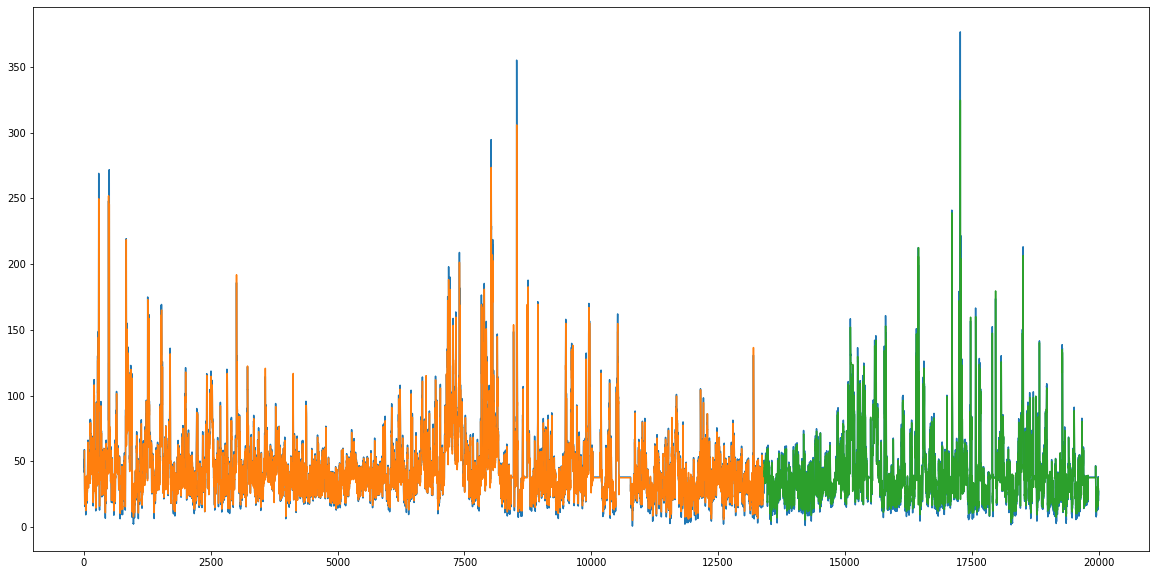

In [16]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dfPollutant)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[seq_len:len(trainPredict)+seq_len, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dfPollutant)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(seq_len*2)+1:len(dfPollutant)-1, :] = testPredict

# plot baseline and predictions
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(scaler.inverse_transform(dfPollutant))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()